## Fun with Gene Vectors
- [Word Vector Experimentation](#2d)
- [Clustering Evaluation](#cluster)
- [Visual clustering on subset of filtered genes](#subset)
- [Image evaluation](#image)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import os; os.chdir('..')
# import tools
from tools.config import TCGA_MUT, GENE2VEC
from tools.utils import *
from tools.gene2vec import *
from tools.cluster import *
from tools.somatic import *

---
#### Word Vector Experimentation
<a id="2d"></a>

For each sample, now want to encode gene2vec embeddings as a prior on mutation data.
- Evaluate separation difference between gene2vec training iterations (checkpoints) (iter_1, iter_5, iter_10)
- Evaluate separation with dimension (16, 128, 1024)
- Evaluate Scree plot (break down of PC's) across dimensions

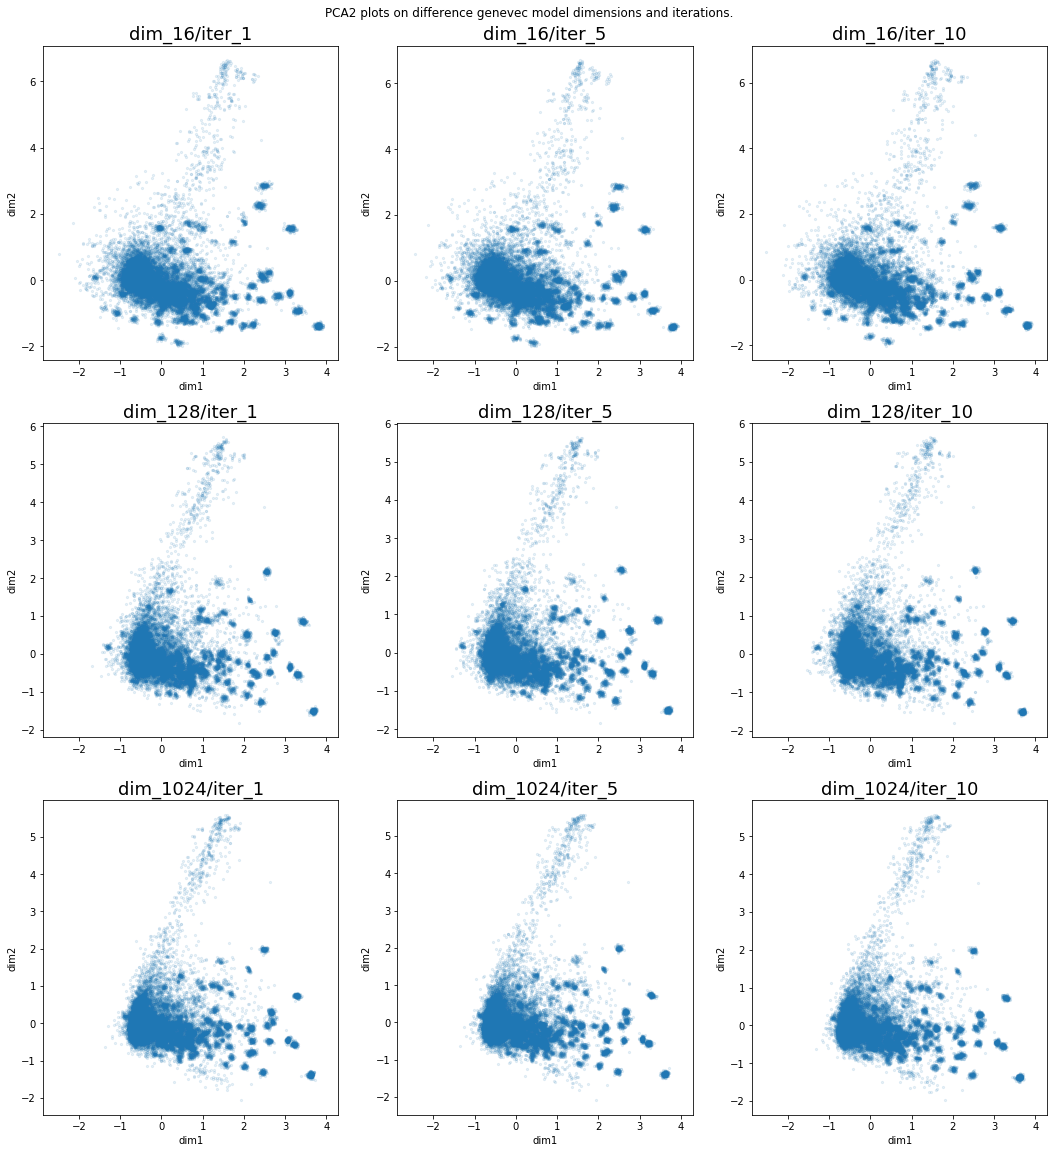

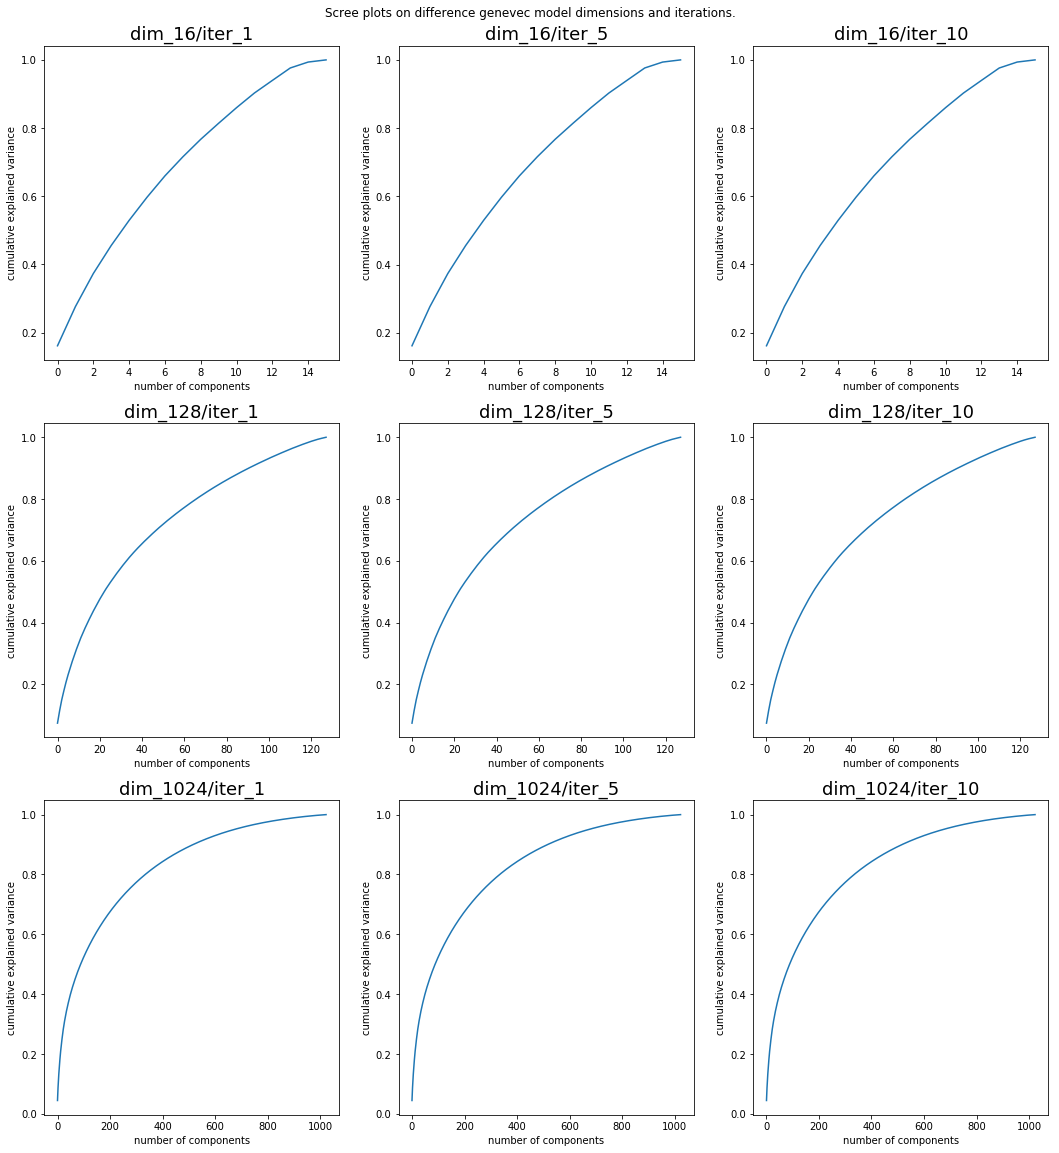

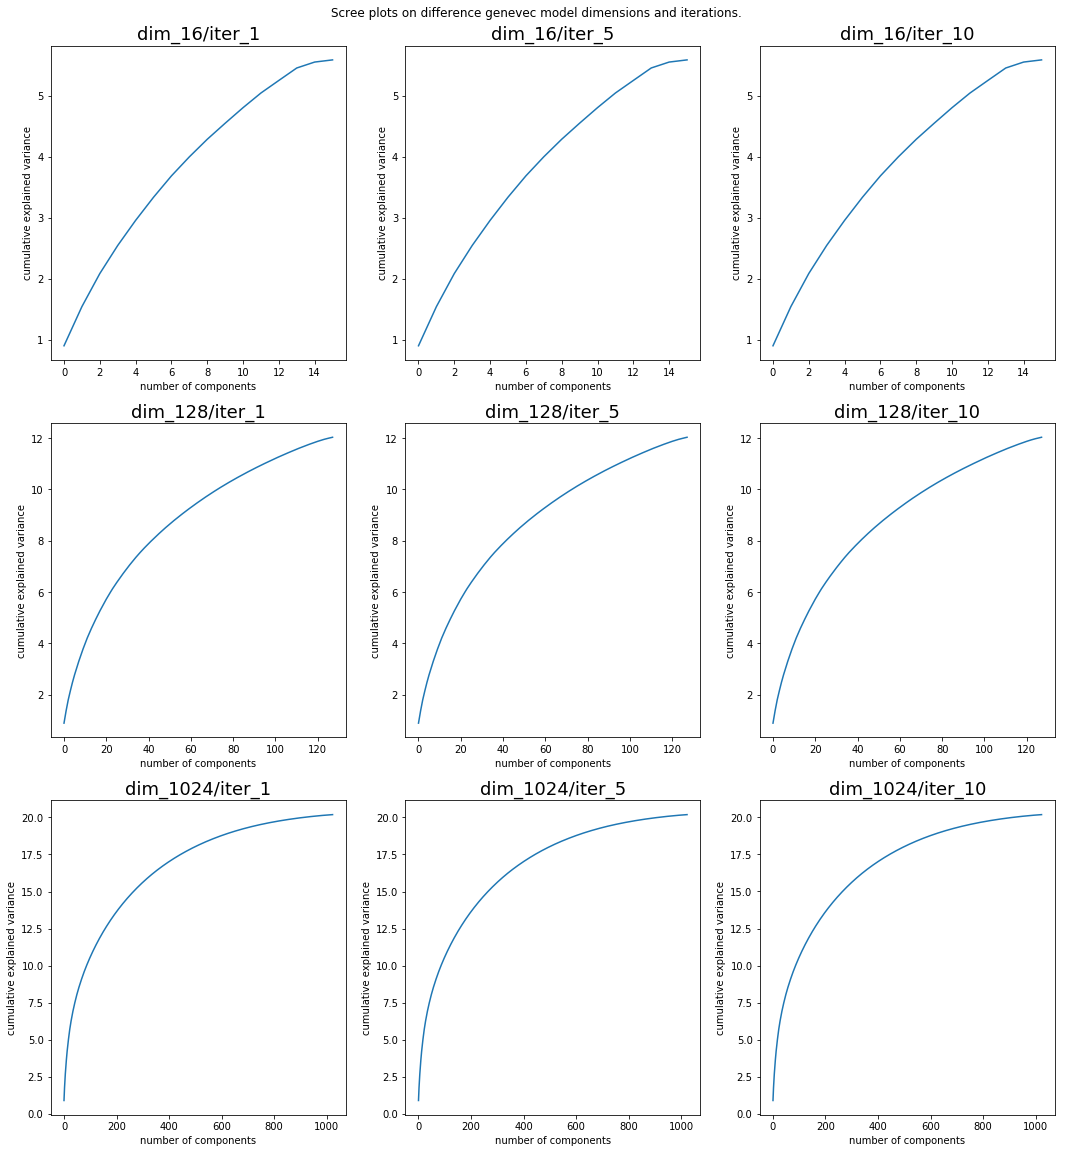

In [3]:
vis_pca2_genevec()
vis_scree_genevec()
vis_scree_genevec(ratio=False)

---

In [12]:
MSIGDB = '../data/gene2vec/msigdb.v6.2.symbols.gmt'

def _get_data(line):
    """
    Read pathway name and set of genes from each line, parsing gene appropriately.
    """
    name, _, genes = line.split("\t", 2)
    return name, set(gene.replace('\n', '') for gene in genes.split("\t"))

def load_msigdb():
    """
    Read msigdb pathways file line by line and parse into useful dataframe.
    """
    with open(MSIGDB, 'r') as fp:
        pathways_df = pd.DataFrame(data=[_get_data(line) for line in fp],
                                   columns=["name", "set"])
        
    return pathways_df

pathways_df = load_msigdb()

In [13]:
cancer_pathways = pathways_df[pathways_df['name'].str.contains('CANCER')]

sets = [s[1]['set'] for s in cancer_pathways.iterrows()]

In [14]:
# generate gene set from known cancer pathways
ras = pathways_df[pathways_df['name'].str.contains('REACTOME_SIGNALLING_TO_RAS')]
nrf2 = pathways_df[pathways_df['name'].str.contains('NRF2')]
tgf_beta = pathways_df[pathways_df['name'].str.contains('TGF_BETA')]
pi3k = pathways_df[pathways_df['name'].str.contains('PI3K')]
wnt = pathways_df[pathways_df['name'].str.contains('WNT_SIG')]
myc = pathways_df[pathways_df['name'].str.contains('_MYC_')]
p53 = pathways_df[pathways_df['name'].str.contains('_P53_')]
cell_cycle = pathways_df[pathways_df['name'].str.contains('_CELL_CYCLE_')]
hippo = pathways_df[pathways_df['name'].str.contains('HIPPO')]
notch = pathways_df[pathways_df['name'].str.contains('NOTCH')]

dfs_ = [ras,nrf2,tgf_beta,pi3k,wnt,myc,p53,cell_cycle,hippo,notch]
names = ['ras','nrf2','tgf_beta','pi3k','wnt','myc','p53','cell_cycle','hippo','notch']
def get_sets(pathways):
    return set.union(*[s[1]['set'] for s in pathways.iterrows()])

setss = [get_sets(df) for df in dfs_]

dfs=[]
for i,name in enumerate(names):
    dfs.append(pd.DataFrame({'genes' : list(setss[i]), 'pathway' : name.upper()}))
    
pathways_df = pd.concat(dfs)

In [15]:
pathways_df['genes']

0          RALA
1          RAF1
2          SHC3
3          NRAS
4           NGF
5          CDK1
6         NTRK1
7          HRAS
8         MAPK3
9          KRAS
10       MAPK13
11         RALB
12       RALGDS
13       MAPK11
14        YWHAB
15         SHC1
16         GRB2
17         SHC2
18       MAP2K1
19         SOS1
20          SRC
21        MAPK1
22     MAPKAPK2
23       MAP2K2
24       MAPK12
25     MAPKAPK3
26       MAPK14
0          FLNC
1         COX15
2         CWC25
         ...   
770       PSME4
771        NOD2
772         CD2
773       CIDEB
774       SGSM3
775        IL7R
776       LCE2B
777        RBPJ
778      MTHFD2
779        KRT9
780        HHEX
781      TNRC6A
782      HDAC10
783       BRCA1
784        CD28
785       ARRB1
786        NID1
787        HEY2
788       NUMBL
789       PHKG1
790       HDAC6
791     SLC39A4
792      TCF7L2
793    KIAA0125
794        CIR1
795       CNGB3
796        DVL2
797     ST3GAL6
798     RAB3IL1
799      ATP2A1
Name: genes, Length: 108

,genes,pathway,pc1,pc2,pathway_y
0,RALA,RAS,-0.558170,-0.071046,OTHER
1,RALA,CELL_CYCLE,-0.558170,-0.071046,OTHER
2,RAF1,RAS,-0.581383,0.209125,OTHER
3,RAF1,PI3K,-0.581383,0.209125,OTHER
4,SHC3,RAS,-0.586772,0.534469,OTHER
5,SHC3,MYC,-0.586772,0.534469,OTHER
6,NRAS,RAS,-0.548300,0.179533,OTHER
7,NRAS,NRF2,-0.548300,0.179533,OTHER
8,NRAS,PI3K,-0.548300,0.179533,OTHER
9,NRAS,MYC,-0.548300,0.179533,OTHER


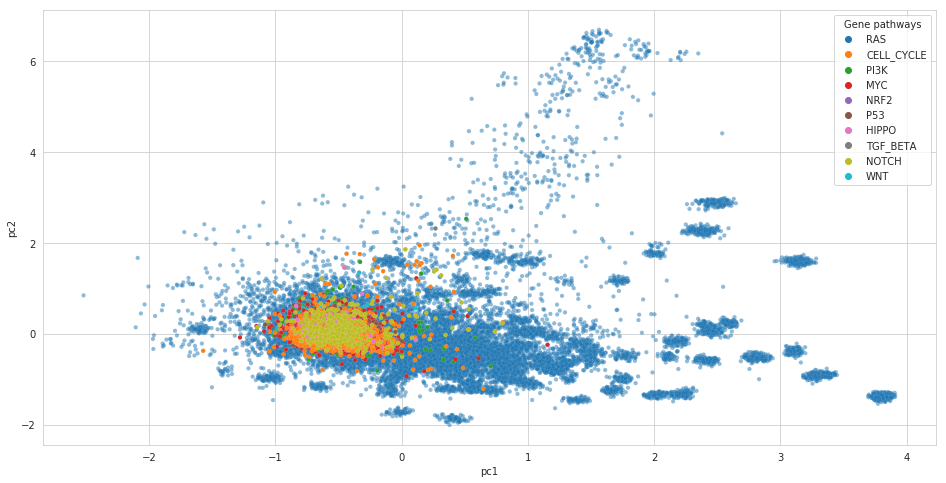

In [48]:
# load data
filename = str(GENE2VEC / 'dim_{}/iter_{}'.format(16, 10))
wv, vocab = load_embeddings(filename)

# run pca_2v
wv_2 = pca_2d(wv)

plot_df = pd.DataFrame({'genes':vocab, 'pc1':wv_2[:,0], 'pc2':wv_2[:,1]})
plot_df['pathway'] = 'OTHER'

df_merge = pd.merge(pathways_df, plot_df, on='genes').rename({'pathway_x':'pathway'}, axis=1)
df_merge

fig = plt.figure(figsize=(16,8))
import seaborn as sns
sns.scatterplot(x="pc1", y="pc2", data=plot_df, alpha=0.5, size=2, linewidth=0.1, legend=False)
g = sns.scatterplot(x="pc1", y="pc2", hue="pathway", data=df_merge, alpha=1, size=2, linewidth=0.1, legend='full')
g.get_legend().set_title("Gene pathways");

# hack to remove legend entries
vpacker = g.get_legend()._legend_handle_box.get_children()[0]
vpacker._children = vpacker.get_children()[1:-1]
fig.savefig(FIGURES/'pca2_pathways.png')

---
---

(-10, 400)

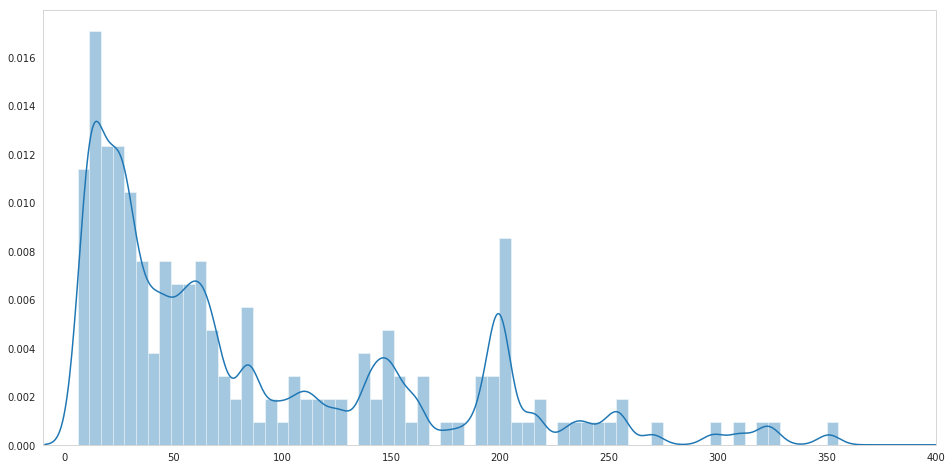

In [50]:
# try training g2v on a subset
cancer_pw_df = pd.concat(dfs_)

data = cancer_pw_df['set'].apply(lambda x: len(x)).sort_values(ascending=False).values
import numpy as np; import matplotlib.pyplot as plt
import seaborn as sns
fig=plt.figure(figsize=(16,8))
sns.set_style('whitegrid')
plt_ = sns.distplot(np.array(data), bins=200, kde_kws={"kernel":"gau", "bw":"5", "gridsize":2000})
plt_.grid(False)
ax = plt_.axes; ax.set_xlim(-10,400)
fig.savefig("../figures/cancer_pathways_dist.png")

In [23]:
GENE2VEC_DIR    = '../models/gene2vec/'
import pickle as pkl
def generate_gene_pairs(gene_set):
    """
    Get gene pairs
    """
    from itertools import combinations
    # Get all combinations of length 2 
    pairs = combinations(list(gene_set), 2)
    return set(pairs)

def get_pairs_set(df):
    """
    Return the set union of all pairs from every gene set within the df.
    """
    return set.union(*df['pairs'].tolist())

# create new pairs set
cancer_pw_df['pairs'] = (cancer_pw_df.set
                                   .apply(generate_gene_pairs))
gene_pairs = cancer_pw_df.pipe(get_pairs_set)
print (len(gene_pairs))
with open (GENE2VEC_DIR+'/cancer_pairs.pkl', 'wb') as f:
    pkl.dump(gene_pairs, f)

2411409


In [ ]:
def train_word2vec(gene_pairs, dimension=W2V_DIMENSION):
    """
    Trains n_iter iterations of word2vec and saves model on each iteration.
    """
    # initialise and save model
    model = gensim.models.Word2Vec(gene_pairs, 
                                   size=dimension,
                                   window=W2V_WINDOW_SIZE, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=W2V_NUM_WORKERS, 
                                   negative=W2V_NEGATIVE,
                                   sg=W2V_SG)
    print("gene2vec model initialised")
    
    current_iter = 0
    filename = 'dim_{}/iter_{}'.format(dimension, current_iter)
    
    model.save(GENE2VEC_DIR + filename)
    print("gene2vec model saved")
    del model 
    
    # train model
    for current_iter in range(1,W2V_N_ITER+1):
        loadfile = 'dim_{}/iter_{}'.format(dimension, current_iter - 1)
        
        # shuffle pairs
        random.shuffle(gene_pairs)
        
        # load model and train on shuffled gene pairs
        model = gensim.models.Word2Vec.load(GENE2VEC_DIR + filename)
        model.train(gene_pairs,total_examples=model.corpus_count,epochs=model.iter)
        
        # save trained model
        model.save(GENE2VEC_DIR + 'dim_{}/iter_{}'.format(dimension, current_iter))
        print("gene2vec dimension " + str(dimension) + " iteration " + str(current_iter) + " saved")
        del model

In [25]:
# initialise and save model
cancer_pairs = list(gene_pairs)
model = gensim.models.Word2Vec(cancer_pairs, 
                               size=128,
                               window=2, 
                               min_count=1, 
                               workers=16, 
                               negative=3,
                               sg=1)
print("gene2vec model initialised")

random.shuffle(cancer_pairs)
model.train(cancer_pairs,total_examples=model.corpus_count,epochs=3,compute_loss=True)

filename = GENE2VEC_DIR + 'ONCO_PAIRS_DIM_{}'.format(128)
model.save(filename)

gene2vec model initialised


(14468454, 14468454)

In [116]:
from gensim.models.keyedvectors import KeyedVectors
def load_embeddings(file_name):
    model = KeyedVectors.load(file_name)
    wordVector = model.wv
    vocabulary, wv = zip(*[[word, wordVector[word]] for word, vocab_obj in wordVector.vocab.items()])
    
    return np.asarray(wv), vocabulary

# load test file
filename = GENE2VEC_DIR + 'ONCO_PAIRS_DIM_{}'.format(128)
wv, vocab = load_embeddings(filename)

In [ ]:
# run pca_2v
wv_2 = pca_2d(wv)

plot_df = pd.DataFrame({'genes':vocab, 'pc1':wv_2[:,0], 'pc2':wv_2[:,1]})
plot_df['pathway'] = 'OTHER'

df_merge = pd.merge(pathways_df, plot_df, on='genes').rename({'pathway_x':'pathway'}, axis=1)
df_merge

fig = plt.figure(figsize=(16,8))
import seaborn as sns
sns.scatterplot(x="pc1", y="pc2", data=plot_df, alpha=0.5, size=2, linewidth=0.1, legend=False)
g = sns.scatterplot(x="pc1", y="pc2", hue="pathway", data=df_merge, alpha=1, size=2, linewidth=0.1, legend='full')
g.get_legend().set_title("Gene pathways");

# hack to remove legend entries
vpacker = g.get_legend()._legend_handle_box.get_children()[0]
vpacker._children = vpacker.get_children()[1:-1]
fig.savefig(FIGURES/'cancer_pathways_pca.png')

In [37]:
# tsne
from sklearn.manifold import TSNE
pca = PCA(n_components=20)

pca.fit(wv)
wv_pc50=pca.transform(wv)

tsne = TSNE(n_components=2, 
            perplexity=30, 
            n_iter=500, 
            learning_rate=200)
data = tsne.fit_transform(wv_pc50)

plot_df = pd.DataFrame({'genes':vocab, 'pc1':data[:,0], 'pc2':data[:,1]})
plot_df['pathway'] = 'OTHER'
df_merge = pd.merge(pathways_df, plot_df, on='genes').rename({'pathway_x':'pathway'}, axis=1)

fig = plt.figure(figsize=(16,8))
import seaborn as sns
sns.scatterplot(x="pc1", y="pc2", data=plot_df, alpha=0.5, size=2, linewidth=0.1, legend=False)
g = sns.scatterplot(x="pc1", y="pc2", hue="pathway", data=df_merge, alpha=1, size=2, linewidth=0.1, legend='full')
g.get_legend().set_title("Gene pathways");

# hack to remove legend entries
vpacker = g.get_legend()._legend_handle_box.get_children()[0]
vpacker._children = vpacker.get_children()[1:-1]
fig.savefig(FIGURES/'cancer_pathways_tsne.png')

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

NameError: name 'plot_2d' is not defined

---


PCA(copy=True, iterated_power='auto', n_components=32, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

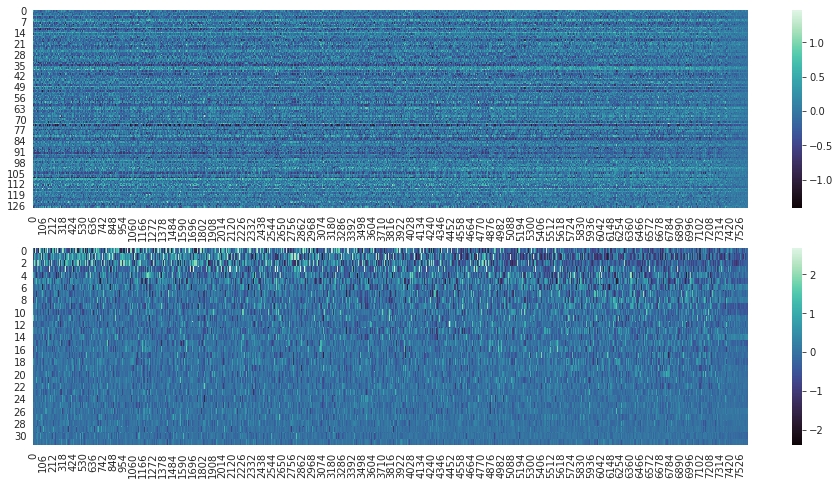

In [124]:
# create new population of images
pca = PCA(n_components=32)
pca.fit(wv)
wv_pc50=pca.transform(wv)

fig, axs = plt.subplots(2,1,figsize=(16,8))
# plot raw matrix
sns.heatmap(wv.transpose(), ax=axs[0], cmap='mako')
# plot pc matrix
sns.heatmap(wv_pc50.transpose(), ax=axs[1], cmap='mako')

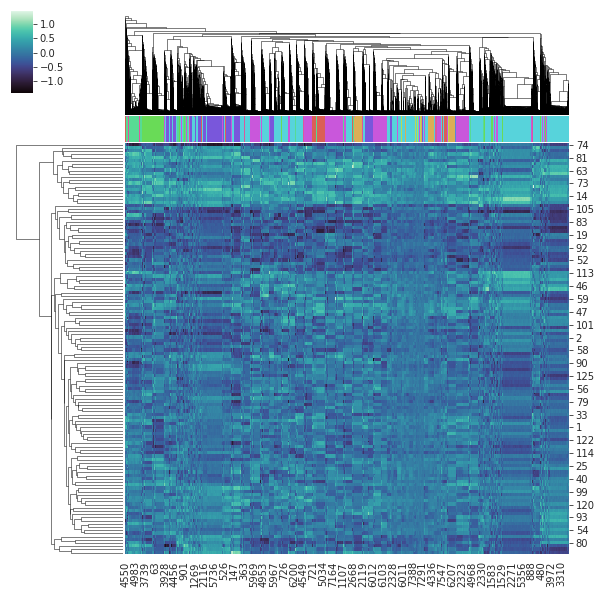

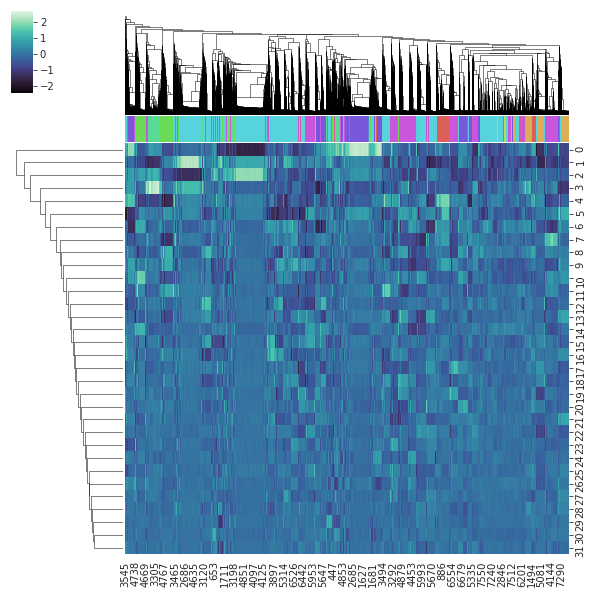

In [173]:
rows = [df_merge[df_merge['genes'] == g].head(1)['pathway'].values[0] for g in vocab]
lut = dict(zip(set(rows), sns.hls_palette(len(set(rows)))))
colors = pd.DataFrame(rows)[0].map(lut)

# try some clustering
grid_ = sns.clustermap(wv.transpose(), col_colors=colors.values, cmap='mako')
grid_pc50 = sns.clustermap(wv_pc50.transpose(), col_colors=colors.values, cmap='mako')

In [122]:
row_order, col_order = grid_.dendrogram_row.reordered_ind, grid_.dendrogram_col.reordered_ind
row_order_, col_order_ = grid_pc50.dendrogram_row.reordered_ind, grid_pc50.dendrogram_col.reordered_ind

---
## Generate data

In [127]:
from tools.cluster import generate_imageset
from tools.dataset import generate_dataset

In [172]:
TCGA = '../data/tcga/processed_somatic_mutations_subset.csv'

import pandas as pd
df_tcga = pd.read_csv(TCGA_MUT)

from tools.config   import TCGA_MUT,GENE2VEC,FIGURES
from tools.utils    import size,freememory
from tools.somatic  import process_labels,filter_variants,filter_genes, \
                           visualise_distributions, dedup, reshape_pivot, \
                           convert_to_onehot, get_label_df

# process and filter
df_X    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='2020+', number=1000)
                  .pipe(dedup)
                  .pipe(reshape_pivot))

df_y    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='2020+', number=1000)
                  .pipe(get_label_df, df_X))

df_somatic = convert_to_onehot(df_X)

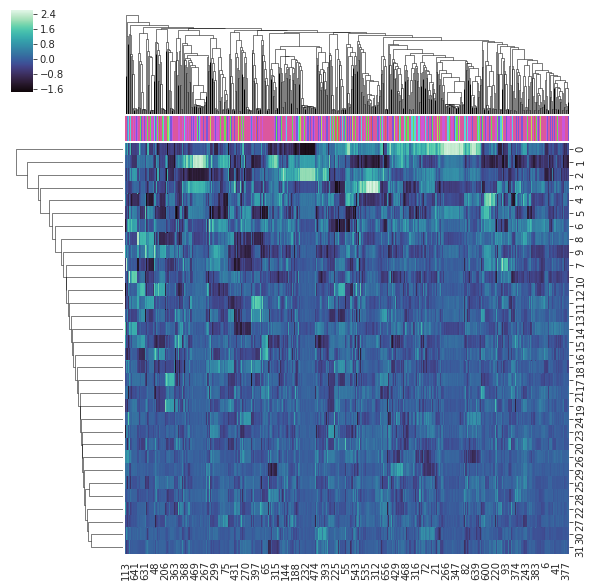

In [174]:
# generate stack of augmented samples
norm=True

df_genevec = pd.DataFrame(wv_pc50.transpose(), columns=vocab)
genes = gene_intersection(df_somatic, df_genevec) # get intersection

# plot clusters
grid_ = sns.clustermap(df_genevec[genes].values, col_colors=colors.values, cmap='mako')
row_order, col_order = grid_.dendrogram_row.reordered_ind, grid_.dendrogram_col.reordered_ind

if norm:
    genevec = MinMaxScaler().fit_transform(df_genevec[genes].values)
else:
    genevec = df_genevec[genes].values

somatic = np.repeat(df_somatic[genes].values[:, :, np.newaxis], genevec.shape[0], axis=2).transpose([0,2,1])
images = somatic * genevec
X = images[:,np.argsort(row_order),:]; del images
X = X[:,:,np.argsort(col_order)]

In [175]:
data_dir = "../data/gene_images/2d_clustering/ONCO_DIM_PC50)"
generate_dataset(X, df_y, data_dir, colour='viridis')

Getting train/test/val split:


---
---
## Do the same thing for 1024 dimensions

In [107]:
# initialise and save model
cancer_pairs = list(gene_pairs)
model = gensim.models.Word2Vec(cancer_pairs, 
                               size=1024,
                               window=2, 
                               min_count=1, 
                               workers=16, 
                               negative=3,
                               sg=1)
print("gene2vec model initialised")

random.shuffle(cancer_pairs)
model.train(cancer_pairs,total_examples=model.corpus_count,epochs=3,compute_loss=True)

gene2vec model initialised


(14468454, 14468454)

NameError: name 'dimension' is not defined

In [108]:
filename = GENE2VEC_DIR + 'ONCO_PAIRS_DIM_{}'.format(1024)
model.save(filename)

In [109]:
from gensim.models.keyedvectors import KeyedVectors
def load_embeddings(file_name):
    model = KeyedVectors.load(file_name)
    wordVector = model.wv
    vocabulary, wv = zip(*[[word, wordVector[word]] for word, vocab_obj in wordVector.vocab.items()])
    
    return np.asarray(wv), vocabulary

# load test file
wv, vocab = load_embeddings(filename)

,genes,pathway,pc1,pc2,pathway_y
0,RALA,RAS,2.098784,0.160388,OTHER
1,RALA,CELL_CYCLE,2.098784,0.160388,OTHER
2,RAF1,RAS,0.347736,-0.465153,OTHER
3,RAF1,PI3K,0.347736,-0.465153,OTHER
4,SHC3,RAS,-0.664116,-0.130335,OTHER
5,SHC3,MYC,-0.664116,-0.130335,OTHER
6,NRAS,RAS,-0.930634,0.555130,OTHER
7,NRAS,NRF2,-0.930634,0.555130,OTHER
8,NRAS,PI3K,-0.930634,0.555130,OTHER
9,NRAS,MYC,-0.930634,0.555130,OTHER


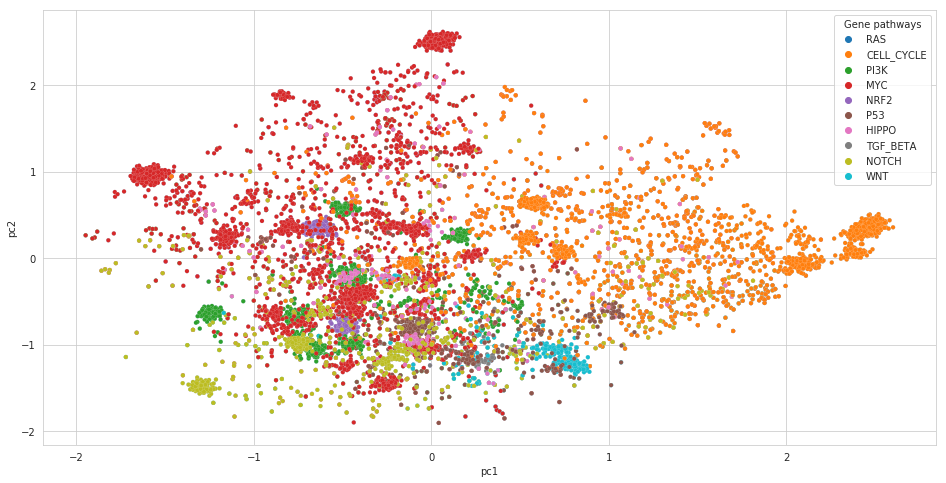

In [110]:
# run pca_2v
wv_2 = pca_2d(wv)

plot_df = pd.DataFrame({'genes':vocab, 'pc1':wv_2[:,0], 'pc2':wv_2[:,1]})
plot_df['pathway'] = 'OTHER'

df_merge = pd.merge(pathways_df, plot_df, on='genes').rename({'pathway_x':'pathway'}, axis=1)
df_merge

fig = plt.figure(figsize=(16,8))
import seaborn as sns
sns.scatterplot(x="pc1", y="pc2", data=plot_df, alpha=0.5, size=2, linewidth=0.1, legend=False)
g = sns.scatterplot(x="pc1", y="pc2", hue="pathway", data=df_merge, alpha=1, size=2, linewidth=0.1, legend='full')
g.get_legend().set_title("Gene pathways");

# hack to remove legend entries
vpacker = g.get_legend()._legend_handle_box.get_children()[0]
vpacker._children = vpacker.get_children()[1:-1]
fig.savefig(FIGURES/'cancer_pathways_pca_1024.png')

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

,genes,pathway,pc1,pc2,pathway_y
0,RALA,RAS,6.703659,14.613179,OTHER
1,RALA,CELL_CYCLE,6.703659,14.613179,OTHER
2,RAF1,RAS,-0.266107,-4.491865,OTHER
3,RAF1,PI3K,-0.266107,-4.491865,OTHER
4,SHC3,RAS,16.993450,-14.957957,OTHER
5,SHC3,MYC,16.993450,-14.957957,OTHER
6,NRAS,RAS,-21.674606,3.348720,OTHER
7,NRAS,NRF2,-21.674606,3.348720,OTHER
8,NRAS,PI3K,-21.674606,3.348720,OTHER
9,NRAS,MYC,-21.674606,3.348720,OTHER


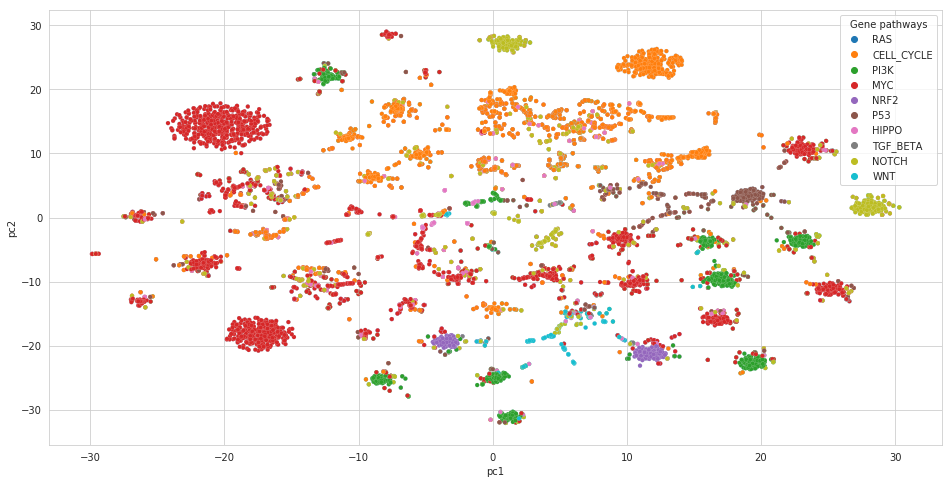

In [113]:
# tsne
from tsnecuda import TSNE
pca = PCA(n_components=100)

pca.fit(wv)
wv_pc100=pca.transform(wv)

tsne = TSNE(n_components=2, 
            perplexity=30, 
            n_iter=500, 
            learning_rate=200)
data = tsne.fit_transform(wv_pc100)

plot_df = pd.DataFrame({'genes':vocab, 'pc1':data[:,0], 'pc2':data[:,1]})
plot_df['pathway'] = 'OTHER'

df_merge = pd.merge(pathways_df, plot_df, on='genes').rename({'pathway_x':'pathway'}, axis=1)
df_merge

fig = plt.figure(figsize=(16,8))
import seaborn as sns
sns.scatterplot(x="pc1", y="pc2", data=plot_df, alpha=0.5, size=2, linewidth=0.1, legend=False)
g = sns.scatterplot(x="pc1", y="pc2", hue="pathway", data=df_merge, alpha=1, size=2, linewidth=0.1, legend='full')
g.get_legend().set_title("Gene pathways");

# hack to remove legend entries
vpacker = g.get_legend()._legend_handle_box.get_children()[0]
vpacker._children = vpacker.get_children()[1:-1]
fig.savefig(FIGURES/'cancer_pathways_tsne_1024.png')

PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

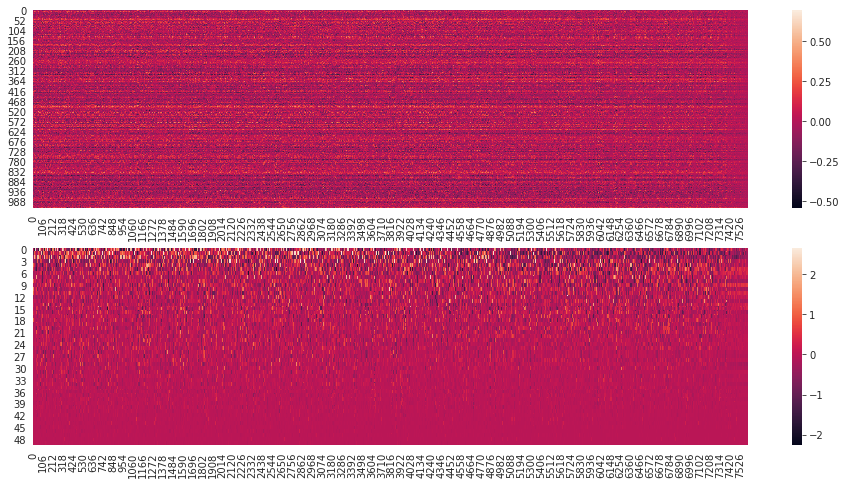

In [114]:
# create new population of images
pca = PCA(n_components=50)
pca.fit(wv)
wv_pc50=pca.transform(wv)

fig, axs = plt.subplots(2,1,figsize=(16,8))
# plot raw matrix
sns.heatmap(wv.transpose(), ax=axs[0])
# plot pc matrix
sns.heatmap(wv_pc50.transpose(), ax=axs[1])

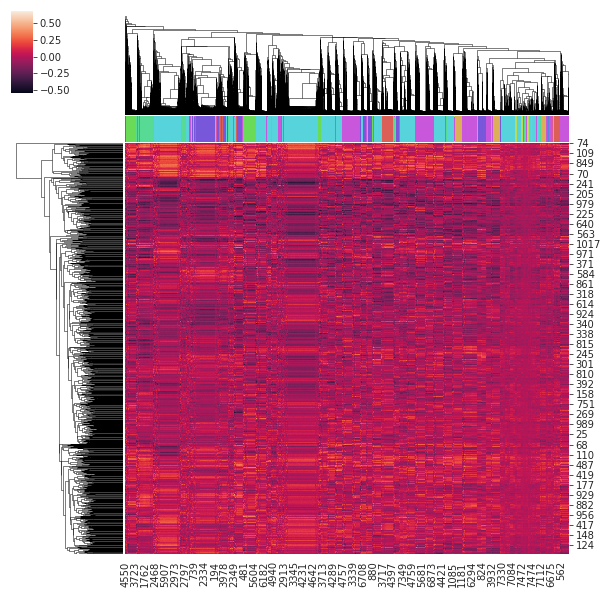

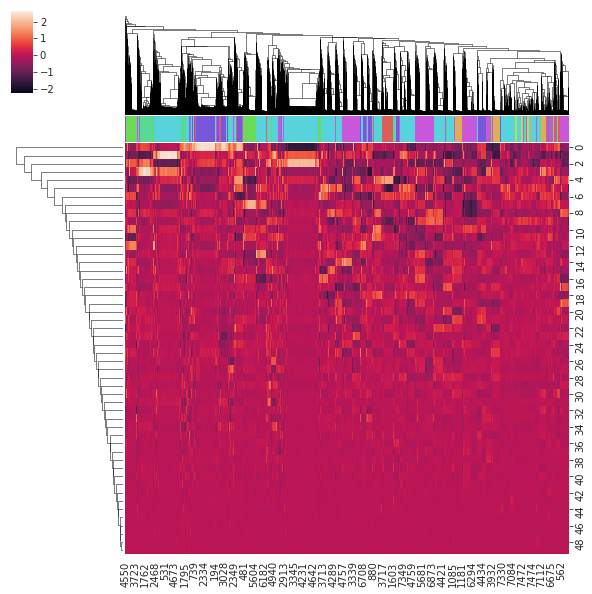

In [115]:
rows = [df_merge[df_merge['genes'] == g].head(1)['pathway'].values[0] for g in vocab]
lut = dict(zip(set(rows), sns.hls_palette(len(set(rows)))))
colors = pd.DataFrame(rows)[0].map(lut)

# try some clustering
sns.clustermap(wv.transpose(), col_colors=colors.values)
sns.clustermap(wv_pc50.transpose(), col_colors=colors.values)

---
#### Clustering Evaluation
<a id="cluster"></a>

Would like to audit available clustering techniques and visualise PCA2 to establish best technique to cluster/order genes. Clustering algorithms are taken from SKLearn and those available to be evaluated are:
- MiniBatchKMeans
- SpectralClustering
- Ward
- DBSCAN
- OPTICS
- Birch
- GaussianMixture

To do:
- Add non-linear kernel PCA
- tSNE on PCA
- Compare with VAE latent space
- [Beta TC-VAE](https://arxiv.org/pdf/1802.04942.pdf)
- [Glow VAE](https://openai.com/blog/glow/)

In [ ]:
%%time
# load data
dim = 256
filename = str(GENE2VEC / 'dim_{}/iter_10'.format(dim))
wv, vocab = load_embeddings(filename)
X = wv
    
pca_degree=[1, 2, 10, 50]
selected_algos = ['MiniBatchKMeans',
                  'DBSCAN',
                  'GaussianMixture']
vis_pca2_clusters(X, pca_degree, selected_algos, n_clusters=50)

---
#### Load and preprocess somatic mutations from [TCGA in BigQuery](https://bigquery.cloud.google.com/table/isb-cgc:TCGA_hg38_data_v0.Somatic_Mutation?pli=1)
<a id="tcga"></a>

- Subset query has already been completed in BQ and saved to Google Cloud Storage
- In absence of MutSigCV results use list of 459 driver genes from [Intogen](https://www.intogen.org/search)

In [ ]:
# load data
import pandas as pd
df_tcga = pd.read_csv(TCGA_MUT)

# process and filter
df_X    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1000)
                  .pipe(dedup)
                  .pipe(reshape_pivot))

df_y    = (df_tcga.pipe(process_labels)
                  .pipe(filter_variants)
                  .pipe(filter_genes, by='mutsigcv', number=1000)
                  .pipe(get_label_df, df_X))

df_somatic = convert_to_onehot(df_X)

# load data
dim = 256
filename = str(GENE2VEC / 'dim_{}/iter_10'.format(dim))
wv, vocab = load_embeddings(filename)

# del df_X
freememory()

---
#### Visualise Clustering on subset of filtered genes
<a id="subset"></a>

- DF_X1 is 'empirical' gene selection using intogen list
- DF_X2 is 'statistical' gene selection

In [ ]:
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
genes = gene_intersection(df_somatic, df_genevec)
merge1 = df_somatic[genes]
merge2 = df_genevec[genes]

pca_degree=[1, 2, 10, 50, 100]
selected_algos = ['MiniBatchKMeans',
                  'Ward',
                  'Birch',
                  'GaussianMixture']
# vis_pca2_clusters(merge2.values.transpose(), pca_degree, selected_algos, alpha=1, n_clusters=10)

In [ ]:
test = convert_to_onehot(df_X2)
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
genes = gene_intersection(test, df_genevec)
merge1 = test[genes]
merge2 = df_genevec[genes]

pca_degree=[1, 2, 10, 50, 100]
selected_algos = ['MiniBatchKMeans',
                  'Ward',
                  'Birch',
                  'GaussianMixture']
# vis_pca2_clusters(merge2.values.transpose(), pca_degree, selected_algos, alpha=1, n_clusters=10)

---
#### Image Evaluation
<a id="image"></a>

Visual comparison of resulting images for a particular sample. Looking at different parameter combinations.
Explore following parameters on images:
- Clustering algorithm for sorting 
    - {GaussianMixture, DBScan, 1D-PCA} vs dimensionality of GeneVectors {64, 256, 512}
    - [Spectral Biclustering](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-biclustering-py) or [Spectral Coclustering](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_coclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-coclustering-py)
- Normalisation on image matrix, resulting distribution on images and images themselves
    - 0,1 normalise on non-zero values only
    - Take absolute value only
- [Colour map](https://matplotlib.org/examples/color/colormaps_reference.html)
    - Favour best visual artefacts
    - For values symmetric around zero, use diverging colour map
    - Otherwise use perceptually uniform sequential colour map

In [ ]:
# get gene subset
filename = str(GENE2VEC) + '/dim_{}/iter_10'.format(32)
wv, vocab = load_embeddings(filename)

df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
gene_subset = df_genevec[genes].values

X = gene_subset
X.shape

# seaborn magic
import seaborn as sns; sns.set(color_codes=True)
sns.clustermap(X, metric="correlation")
sns.clustermap(X, standard_scale=1)
# pd.DataFrame(X.transpose())

In [ ]:
dims=[32, 128]
clustering_algos = ['MiniBatchKMeans',
                    'DBSCAN']

genes = gene_intersection(convert_to_onehot(df_X), 
                          pd.DataFrame(wv.transpose(), columns=vocab))

fig = plt.figure(figsize=(16, 8))
vis_clustered_images(genes, dims, clustering_algos, n_clusters=50); 
fig.tight_layout(); fig.subplots_adjust(top=0.9); fig.show()

fig.savefig(FIGURES/'clustered_matrices.png')

#### Clustering in both dimensions (vector dimesnion and genes)

In [ ]:
from cluster import *

dims=[16, 32, 128, 512]
clustering_algos = ['MiniBatchKMeans',
                    'Ward',
                    'Birch',
                    'SpectralClustering']

genes = gene_intersection(convert_to_onehot(df_X1),
                          pd.DataFrame(wv.transpose(), columns=vocab))

vis_clustered_2d(genes, clustering_algos, clusters=[1,2,5,50])

---

In [ ]:
colours = ['viridis','magma','gray','seismic']
norms = ['none','non-zero','abs value']

# load data
filename = GENE2VEC_DIR + 'dim_{}/iter_10'.format(128)
wv, vocab = load_embeddings(filename)

# get gene subset
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
df_somatic = convert_to_onehot(df_X1)

genes = gene_intersection(df_somatic, df_genevec)

# initialise algos on gene subset
X = df_genevec[genes].values.transpose()

# y_preds1
algos = init_algos(X.transpose())
algos = tuple([algo for algo in algos if algo[0] in ['MiniBatchKMeans']])
y_preds = Parallel()(delayed(cluster_job)((name, algo, X.transpose())) for name, algo in algos)
y_pred1 = y_preds[0]

# y_preds2
algos = init_algos(X)
algos = tuple([algo for algo in algos if algo[0] in ['MiniBatchKMeans']])
y_preds = Parallel()(delayed(cluster_job)((name, algo, X)) for name, algo in algos)
y_pred2 = y_preds[0]

vis_image_norm_colours(df_genevec[genes], df_somatic[genes], y_pred1, y_pred2, norms, colours)

#### Experiments
- Visualise distribution of values in sample

In [ ]:
vis_norm_histogram(df_genevec[genes], df_somatic[genes], y_pred1, norms)

---

### Saving Cross Sections of Interest

In [ ]:
from cluster import generate_imageset
from dataset import generate_dataset

In [ ]:
dims = [32, 128]
clustering = ['MiniBatchKMeans']
colours = ['viridis']
norms = ['non-zero']

# load somatic mutations
tcga_raw = pd.read_csv(TCGA)
df_X0 = (tcga_raw.pipe(process_labels)
                 .pipe(filter_variants)
                 .pipe(filter_intogen_drivers)
                 .pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))
df_y0 = (tcga_raw.pipe(process_labels)
                 .pipe(filter_variants)
                 .pipe(filter_intogen_drivers)
                 .pipe(get_label_df, df_X0))
df_y = df_y0
df_somatic = convert_to_onehot(df_X0)

for dim in dims:
    # load gene vectors
    filename = GENE2VEC_DIR + 'dim_{}/iter_10'.format(dim)
    wv, vocab = load_embeddings(filename)
    df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
    genes = gene_intersection(df_somatic, df_genevec)
    X = df_genevec[genes].values.transpose()
    
    # get clusters in parallel from algos
    algos = init_algos(X.transpose())
    algos = tuple([algo for algo in algos if algo[0] in clustering])
    clusters1 = Parallel()(delayed(cluster_job)((name, algo, X.transpose())) for name, algo in algos)
    
    # get clusters in parallel from algos
    algos = init_algos(X)
    algos = tuple([algo for algo in algos if algo[0] in clustering])
    clusters2 = Parallel()(delayed(cluster_job)((name, algo, X)) for name, algo in algos)
    
    for i, alg in enumerate(clustering):
        # create df_X and df_y
        cluster1 = clusters1[i]
        cluster2 = clusters2[i]
        for norm in norms:
            df_X = generate_imageset(df_genevec[genes], df_somatic[genes], cluster1, cluster2, norm)    
        
            for colour in colours:
                # choose data dir
                data_dir = "../data/genevec_images/2d_clustering/dim={}_alg={}_norm={}_col={}".format(dim, alg, norm, colour)
                
                # generate dataset
                generate_dataset(df_X, df_y, data_dir, colour=colour)